<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.maskrcnn_resnet50_fpn

In [34]:
import torch
import torchvision as tv
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm
import tqdm.auto

class CFG():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
tv.datasets.OxfordIIITPet('/content/', download=True, target_types='segmentation')

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /content/

In [41]:
df = pd.read_csv(
    "/content/oxford-iiit-pet/annotations/list.txt",
    delimiter=" ",
    skiprows=6,
    header=None,
    names=["stem", "class_id", "species", "breed"]
)
df["class_name"] = df.stem.map(lambda x: x.split("_")[0])
df["image"] = df.stem.map(lambda x: f"/content/oxford-iiit-pet/images/{x}.jpg")
df["trimap"] = df.stem.map(lambda x: f"/content/oxford-iiit-pet/annotations/trimaps/{x}.png")

classes = df['class_id'].unique()
df

,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,/content/oxford-iiit-pet/images/Abyssinian_100...,/content/oxford-iiit-pet/annotations/trimaps/A...
1,Abyssinian_101,1,1,1,Abyssinian,/content/oxford-iiit-pet/images/Abyssinian_101...,/content/oxford-iiit-pet/annotations/trimaps/A...
2,Abyssinian_102,1,1,1,Abyssinian,/content/oxford-iiit-pet/images/Abyssinian_102...,/content/oxford-iiit-pet/annotations/trimaps/A...
3,Abyssinian_103,1,1,1,Abyssinian,/content/oxford-iiit-pet/images/Abyssinian_103...,/content/oxford-iiit-pet/annotations/trimaps/A...
4,Abyssinian_104,1,1,1,Abyssinian,/content/oxford-iiit-pet/images/Abyssinian_104...,/content/oxford-iiit-pet/annotations/trimaps/A...
...,...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,yorkshire,/content/oxford-iiit-pet/images/yorkshire_terr...,/content/oxford-iiit-pet/annotations/trimaps/y...
7345,yorkshire_terrier_97,37,2,25,yorkshire,/content/oxford-iiit-pet/images/yorkshire_terr...,/content/oxford-iiit-pet/annotations/trimaps/y...
7346,yorkshire_terrier_98,37,2,25,yorkshire,/content/oxford-iiit-pet/images/yorkshire_terr...,/content/oxford-iiit-pet/annotations/trimaps/y...
7347,yorkshire_terrier_99,37,2,25,yorkshire,/content/oxford-iiit-pet/images/yorkshire_terr...,/content/oxford-iiit-pet/annotations/trimaps/y...


In [26]:
train_df, val_df = train_test_split(df, stratify = df['class_id'], test_size=0.1)

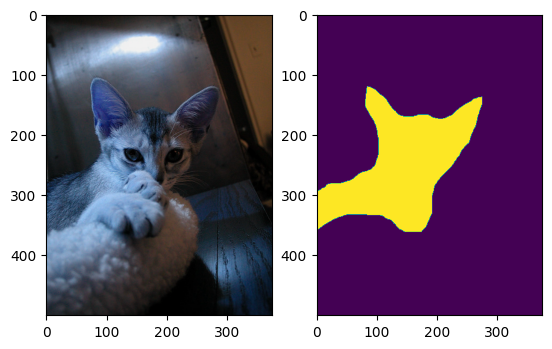

In [78]:
plt.subplot(1,2,1)
img = cv2.imread(df['image'][10])
plt.imshow(img)
plt.subplot(1,2,2)
mask = cv2.imread(df['trimap'][10],0)
mask[np.where(mask==3)] = 0
mask[np.where(mask==2)] = 0
plt.imshow(mask/3)

# train

In [51]:
class mask_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df_se = self.df.iloc[idx, : ]
        img = cv2.cvtColor(cv2.imread(df_se['image']), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512))
        img = torch.tensor(img, dtype=torch.float32) / 255
        img = img.permute(2, 0, 1)

        mask = cv2.imread(df_se['trimap'], 0)
        mask = cv2.resize(mask, (512,512))
        mask[np.where(mask==3)] = 0
        mask[np.where(mask==2)] = 0

        box_x1, box_x2 = np.where(mask == 1)[1].min(), np.where(mask == 1)[1].max()
        box_y1, box_y2 = np.where(mask == 1)[0].min(), np.where(mask == 1)[0].max()
        boxes = [[box_x1, box_y1, box_x2, box_y2]]
        boxes =  torch.tensor(boxes, dtype=torch.float32)

        mask = torch.tensor(mask, dtype=torch.uint8)
        mask = mask.unsqueeze(dim=0)

        label = torch.tensor([df_se['class_id']-1], dtype=torch.int64)

        targets = {'boxes' : boxes, 'labels' : label, 'masks' : mask}

        return img, targets


In [52]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = mask_dataset(train_df)
val_df =  mask_dataset(val_df)
train_dr = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dr = torch.utils.data.DataLoader(val_df, batch_size=4, collate_fn=collate_fn)

In [53]:
model = tv.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [43]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes))
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, hidden_layer, len(classes)+1)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [54]:
def train_model(train_dr, val_dr, model, optimizer):

    model = model.to(CFG.device)
    model.train()
    for i, (train_x, train_y) in enumerate(tqdm.auto.tqdm(train_dr)):
        images = [image.to(CFG.device) for image in train_x]
        targets = [{k: v.to(CFG.device) for k, v in t.items()} for t in train_y]

        losses = model(images, targets)
        loss = sum(loss for loss in losses.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"\r C: {losses['loss_classifier'].item():.5f}, M: {losses['loss_mask'].item():.5f}, "\
                f"B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}", end="")

    model.eval()
    with torch.no_grad():
        val_accs = 0
        for i, (val_x, val_y) in enumerate(val_dr):
            images = [image.to(CFG.device) for image in val_x]
            targets = [{k: v.to(CFG.device) for k, v in t.items()} for t in val_y]

            losses = model(images, targets)
            loss = sum(loss for loss in losses.values())

        print(f" ,C: {losses['loss_classifier'].item():.5f}, M: {losses['loss_mask'].item():.5f}, "\
                f"B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}")

    # return losses/len(train_dr),  val_losses/len(val_dr), accs/len(train_dr), val_accs/len(val_dr)

In [55]:
for epoch in range(10):
    train_model(train_dr, val_dr, model, optimizer)

  0%|          | 0/1654 [00:00<?, ?it/s]

 C: 0.50817, M: 0.92762, B: 0.07870, O: 0.00415, T: 1.52248

KeyboardInterrupt: ignored

In [65]:
model.eval()
img = cv2.imread(df['image'][2])
img = torch.tensor(img, dtype=torch.float32) / 255
img = img.permute(2,0,1)
img = img.unsqueeze(dim=0)
with torch.no_grad():
    pre = model(img)

In [66]:
len(pre[0]['masks'])

13

In [69]:
pre[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

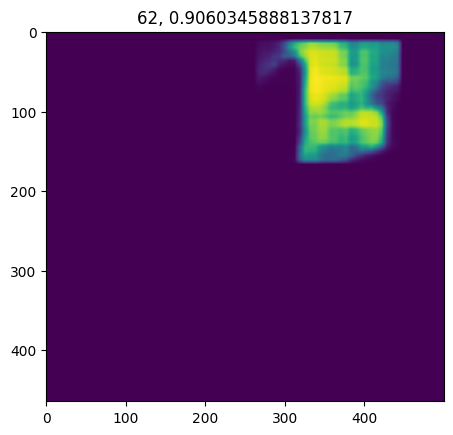

In [68]:
plt.title(f"{pre[0]['labels'][2]}, {pre[0]['scores'][1].item()}")
plt.imshow(pre[0]['masks'][2][0])